In [1]:
from collections import OrderedDict
import sys
from pathlib import Path
import json
import time
import math
import csv
from datetime import datetime
import random
from random import randint
import itertools
import torchvision.utils as vutils

import gc

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.manifold import TSNE
import sklearn.cluster

import cv2

import kornia
import kornia.augmentation as kaug

import torch
import torch.nn as nn

import torchvision as tv
from torchvision.models import resnet50, ResNet50_Weights, resnet34
from torchvision.transforms import functional as tfunc

sys.path.append('../mine_soar')
import MalmoPython
from utils import draw_image, draw_layers, MinecraftHandler

MISSION_PORT = 9001
VIDEO_SHAPE = (256, 256)
VIDEO_DEPTH = 3
DEVICE = 'cuda:0'
# DEVICE = 'cpu'

mc_handler = MinecraftHandler(VIDEO_SHAPE)

def start_mission(file="random_world.xml", seed=b''):
    mc_handler.start_mission(file, seed)

def get_mc_img(show=False):
    image = mc_handler.get_image()
    
    if show:
        draw_image(image, show=True)
    return image

In [2]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_dims, mid_dims, out_dims, padding="zeros", downscale=False, upscale=False, non_linearity=nn.LeakyReLU):
        super().__init__()
        
        self.downscale = downscale
        self.upscale = upscale
        
        if downscale:
            self.downscale_layer = nn.Sequential(
                nn.Conv2d(in_dims, in_dims, 3, 2, 1, padding_mode=padding),
                nn.BatchNorm2d(in_dims),
                non_linearity()
            )
            
        self.dim_compress = nn.Sequential(
            nn.Conv2d(in_dims, mid_dims, 1, 1, 0),
            nn.BatchNorm2d(mid_dims),
            non_linearity()
        )
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(mid_dims, mid_dims, 5, 1, 2, padding_mode=padding),
            nn.BatchNorm2d(mid_dims),
            non_linearity()
        )
        
        self.dim_extend = nn.Sequential(
            nn.Conv2d(mid_dims, out_dims, 1, 1, 0),
            nn.BatchNorm2d(out_dims),
            non_linearity()
        )
        
        if upscale:
            self.upscale_layer = nn.Sequential(
                nn.ConvTranspose2d(out_dims, out_dims, 2, 2, 0),
                nn.BatchNorm2d(out_dims),
                non_linearity()
            )
        
    def forward(self, x):
        if self.downscale:
            x = self.downscale_layer(x)
        x = self.dim_compress(x)
        x = self.bottleneck(x)
        x = self.dim_extend(x)
        if self.upscale:
            x = self.upscale_layer(x)
        return x

In [3]:
pad_mode = "replicate"

class Encoder(nn.Module):
    def __init__(self, num_feats=256):
        super().__init__()
        self.main = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(3, num_feats//2, kernel_size=(1, 1), stride=(1, 1), padding_mode=pad_mode),
                nn.BatchNorm2d(num_feats//2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.LeakyReLU(negative_slope=0.01)
            ),
            nn.Sequential(
                BottleneckBlock(num_feats//2, num_feats//4, num_feats, padding=pad_mode, downscale=True, non_linearity=nn.LeakyReLU),
                BottleneckBlock(num_feats, num_feats//2, num_feats, padding=pad_mode, upscale=True, non_linearity=nn.LeakyReLU),
            ),
            nn.Sequential(
                nn.Conv2d(num_feats, num_feats, 1, 1),
                nn.BatchNorm2d(num_feats),
                nn.LeakyReLU(),
                nn.Conv2d(num_feats, num_feats, 1, 1),
                nn.BatchNorm2d(num_feats),
                nn.LeakyReLU(),
                nn.Conv2d(num_feats, num_feats, 1, 1),
                nn.BatchNorm2d(num_feats),
                nn.LeakyReLU(),
            )
        )
        
        self.opt_method = torch.optim.Adagrad
        self.lr = 1e-3
        
    def forward(self, x):
        return self.main(x)

In [4]:
class Decoder(nn.Module):
    def __init__(self, num_feats=256):
        super().__init__()
        self.main = nn.Sequential(
            nn.Sequential(
                BottleneckBlock(num_feats, num_feats//4, num_feats//2, padding="replicate", upscale=True),
                BottleneckBlock(num_feats//2, num_feats//4, num_feats//2, padding="replicate", downscale=True)
            ),
            nn.Sequential(
                nn.Conv2d(num_feats//2, num_feats//2, 1, 1),
                nn.BatchNorm2d(num_feats//2),
                nn.LeakyReLU(),
                nn.Conv2d(num_feats//2, num_feats//2, 1, 1),
                nn.BatchNorm2d(num_feats//2),
                nn.LeakyReLU(),
                nn.Conv2d(num_feats//2, num_feats//4, 1, 1),
                nn.BatchNorm2d(num_feats//4),
                nn.LeakyReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(num_feats//4, 3, 1, 1, padding_mode=pad_mode),
                nn.BatchNorm2d(3),
                nn.Sigmoid()
            )
        )
        
        self.opt_method = torch.optim.Adagrad
        self.lr = 1e-3
        
    def forward(self, x):
        return self.main(x)

In [5]:
def test_model(models, iters=10001, show_step=250, save_step=250, reset_step=250, seed=2):
    random.seed(seed)
    
    enc_model, dec_model = models
    enc_model_optim = enc_model.opt_method(enc_model.parameters(), enc_model.lr)
    dec_model_optim = dec_model.opt_method(dec_model.parameters(), dec_model.lr)

    if not mc_handler.is_running:
        start_mission(seed=random.randbytes(16))

    session_id = f"{datetime.strftime(datetime.now(), '%Y-%m-%d_%H-%M-%S')}"
    save_root = Path("./runs/"+session_id+"/")
    save_root.mkdir()

    losses_record = []
    images_record = []

    try:
        for i in range(iters):
            mc_handler.sendCommand(f"setYaw {(i*(359/reset_step))%360}")
            try:
                img_tens = get_mc_img(False)
                img_tens = img_tens.to(DEVICE)
            except Exception as e:
                print(e)
                start_mission()
                continue

            model_enc = enc_model(img_tens)
            model_out = dec_model(model_enc)
            loss = ae_loss_fn(model_out, img_tens)
            loss.backward()
            dec_model_optim.step()
            enc_model_optim.step()
            enc_model_optim.zero_grad()
            dec_model_optim.zero_grad()

            losses_record.append(loss.item())
            if i % reset_step == 1:
                print(f"{i}: {loss.item()}")
                images = [img_tens, model_out]
                images = [i.squeeze() for i in images]
                grid_image = vutils.make_grid(images, nrow=int((len(models)+1)**0.5), padding=0, pad_value=0.5, normalize=True).cpu()
                draw_image(grid_image, show=True)
                images_record.append([i.detach().cpu().squeeze() for i in images])

            if i % show_step == 0:
                print(f"{i}: {loss.item()}")
                images = [img_tens, model_out]
                images = [i.squeeze() for i in images]
                grid_image = vutils.make_grid(images, nrow=int((len(models)+1)**0.5), padding=0, pad_value=0.5, normalize=True).cpu()
                draw_image(grid_image, show=True)
                images_record.append([i.detach().cpu().squeeze() for i in images])
            if reset_step is not None and i % reset_step == 0 and i > 0 and i != iters-1:
                mc_handler.sendCommand("quit")
                start_mission(seed=random.randbytes(16))
    except KeyboardInterrupt as e:
        print(e)

    with open(save_root.joinpath("losses.csv"), "w") as csv_file:
        for i, loss in enumerate(losses_record):
            csv_file.write(f"{i},{loss},\n")
    for i, imgs in enumerate(images_record):
        for j, img in enumerate(imgs):
            draw_image(img, save_root.joinpath(f"images_{i*show_step}_{j}.png"))
    plt.figure(figsize=(16, 8))
    plt.plot(losses_record)
    plt.savefig(save_root.joinpath("losses.png"))
    plt.show()
    plt.close()

    mc_handler.sendCommand("quit")

In [6]:
encoder_l1 = Encoder(64).to(DEVICE)
decoder_l1 = Decoder(64).to(DEVICE)

In [7]:
ae_loss_fn = nn.MSELoss()
encoder_l1_optim = torch.optim.Adagrad(encoder_l1.parameters(), lr=1e-3)
decoder_l1_optim = torch.optim.Adagrad(decoder_l1.parameters(), lr=1e-3)

0: 0.09297950565814972


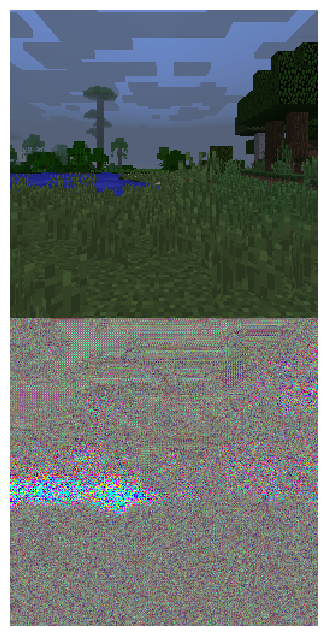

1: 0.1080053448677063


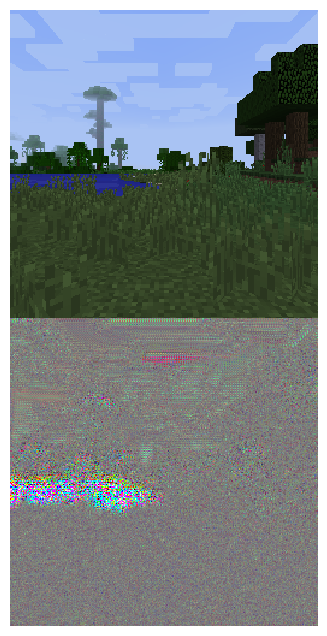

250: 0.01788952201604843


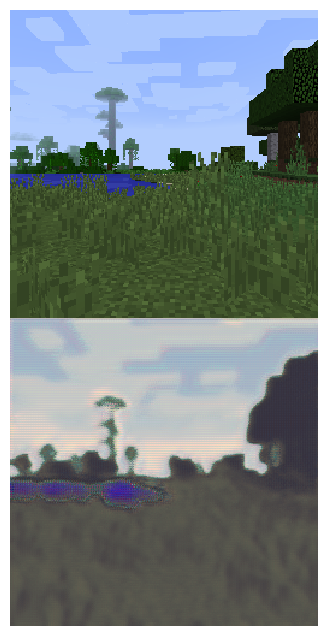

251: 0.0172935351729393


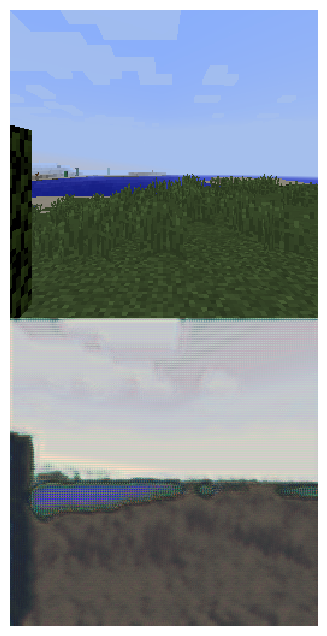

500: 0.018846986815333366


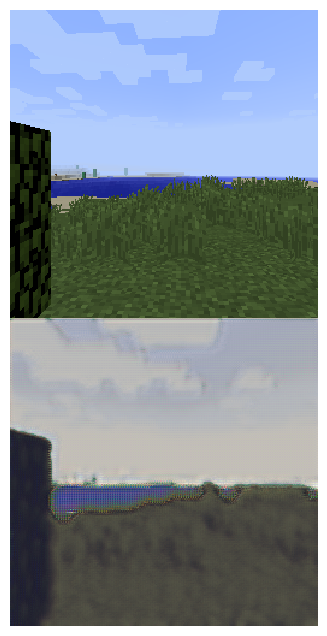

501: 0.17448614537715912


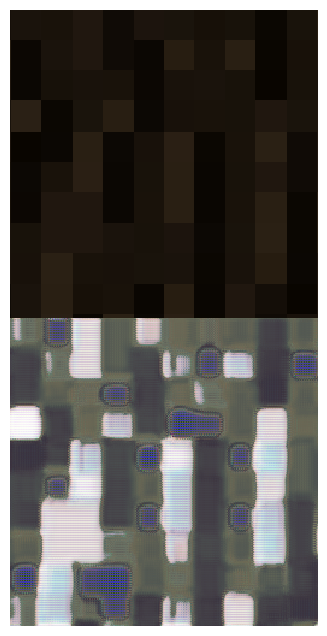

In [ ]:
test_model(models=[encoder_l1, decoder_l1], iters=1001)

In [ ]:
aug_1 = kaug.AugmentationSequential(
#     kaug.RandomResizedCrop((128, 128), scale=(0.2,0.8), cropping_mode="resample"),
    kaug.RandomCrop((VIDEO_SHAPE[0]//2, VIDEO_SHAPE[1]//2), cropping_mode="resample"),
    kaug.ColorJiggle(0.05, 0.05, 0.05, 0.05, p=1.0),
    kaug.RandomVerticalFlip(),
    kaug.RandomHorizontalFlip(),
    data_keys=["input"],  # Just to define the future input here.
    same_on_batch=False,
)
aug_2 = kaug.AugmentationSequential(
#     kaug.RandomResizedCrop((128, 128), scale=(0.2,0.8), cropping_mode="resample"),
    kaug.RandomCrop((VIDEO_SHAPE[0]//2, VIDEO_SHAPE[1]//2), cropping_mode="resample"),
    kaug.ColorJiggle(0.05, 0.05, 0.05, 0.05, p=1.0),
    kaug.RandomVerticalFlip(),
    kaug.RandomHorizontalFlip(),
    data_keys=["input"],  # Just to define the future input here.
    same_on_batch=False,
)

In [ ]:
start_mission(seed=random.randbytes(16))

In [ ]:
img_tens = get_mc_img(True)
img_tens = img_tens.to(DEVICE)

In [ ]:
aug_img_tens_1 = aug_1(img_tens)
aug_img_tens_2 = aug_2(img_tens)

In [ ]:
draw_image(aug_img_tens_1, show=True)
draw_image(aug_img_tens_2, show=True)

In [ ]:
aug_img_tens_1_inv = aug_1.inverse(*aug_img_tens_1)
aug_img_tens_2_inv = aug_2.inverse(*aug_img_tens_2)
draw_image(aug_img_tens_1_inv, show=True)
draw_image(aug_img_tens_2_inv, show=True)

In [ ]:
white_standin = torch.ones((1,1,VIDEO_SHAPE[0]//2,VIDEO_SHAPE[1]//2)).to(DEVICE)
filled_cells_1 = aug_1.inverse(white_standin)
filled_cells_2 = aug_2.inverse(white_standin)
overlap_cells = (filled_cells_1 + filled_cells_2 == 2)
overlap_cells = overlap_cells

In [ ]:
draw_image(filled_cells_1.to(torch.float32), show=True)
draw_image(filled_cells_2.to(torch.float32), show=True)
draw_image(overlap_cells.to(torch.float32), show=True)

In [ ]:
encoded_l1_aug_1 = encoder_l1(aug_img_tens_1)
encoded_l1_aug_2 = encoder_l1(aug_img_tens_2)
encoded_l1_aug_1_inv = aug_1.inverse(*encoded_l1_aug_1)
encoded_l1_aug_2_inv = aug_2.inverse(*encoded_l1_aug_2)
print(encoded_l1_aug_1_inv.shape)

In [ ]:
draw_image(torch.where(overlap_cells, encoded_l1_aug_1_inv[0][:1], 1.0), show=True)

In [ ]:
draw_image(torch.where(overlap_cells, encoded_l1_aug_2_inv[0][:1], 1.0), show=True)

In [ ]:
embed_transformer_enc_layer = torch.nn.TransformerEncoderLayer(256, 8).to(DEVICE)

In [ ]:
encoded_l1_aug_1_inv_flat = encoded_l1_aug_1_inv.reshape((256,256*256)).transpose(0,1)

In [ ]:
embed_transformer_enc_layer(encoded_l1_aug_1_inv_flat)